<a href="https://colab.research.google.com/github/tushardhamani/industrial-real-estate-prediction/blob/master/LaggedCorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [1]:
import requests
import json
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import keras
import seaborn as sns
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from sklearn.preprocessing import Normalizer
import h5py
from keras import backend as K
import io

Using TensorFlow backend.


API DEF

In [0]:
API_ENDPOINT = "https://gmaatest.azurewebsites.net/api/HttpTriggerCSharp1?code=COXmk9ou6Mr8/dUCYj045SaeNm6jCkPzJ3ilU/dCiTvNcFNQax4BMQ=="
QUAND_CASS = "https://www.quandl.com/api/v3/datasets/CASS/CFI.json?api_key=Kcxxx_nHsCG7xiM_yKgY"
QUAND_PRR = "https://www.quandl.com/api/v3/datasets/ZILLOW/M1_PRRAH.json?api_key=Kcxxx_nHsCG7xiM_yKgY"
QUAND_OIL = "https://www.quandl.com/api/v3/datasets/OPEC/ORB.json?api_key=Kcxxx_nHsCG7xiM_yKgY"
QUAND_CCI = "https://www.quandl.com/api/v3/datasets/OECD/KEI_CSCICP02_USA_ST_M.json?api_key=Kcxxx_nHsCG7xiM_yKgY"

API CALL

In [0]:
q = requests.get(url = QUAND_CASS)
q_json = q.json() 
q_data = q_json['dataset']['data']

q2 = requests.get(url = QUAND_PRR)
q2_json = q2.json() 
q2_data = q2_json['dataset']['data']

q3 = requests.get(url = QUAND_OIL)
q3_json = q3.json() 
q3_data = q3_json['dataset']['data']

q4 = requests.get(url = QUAND_CCI)
q4_json = q4.json() 
q4_data = q4_json['dataset']['data']



QUANDL COMPUTE

In [26]:
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)

dates2 = []
values2 = []
q2_len = len(q2_data)
column2_len = len(q2_data[0])
column2 = column2_len-1
columns2 = q2_json['dataset']['column_names']
print (columns2)

dates3 = []
values3 = []
q3_len = len(q3_data)
column3_len = len(q3_data[0])
column3 = column3_len-1
columns3 = q3_json['dataset']['column_names']
print (columns3)

dates4 = []
values4 = []
q4_len = len(q4_data)
column4_len = len(q4_data[0])
column4 = column4_len-1
columns4 = q4_json['dataset']['column_names']
print (columns4)

['Date', 'Shipments', 'Expenditures']
['Date', 'Value']
['Date', 'Value']
['Date', 'Value']


In [27]:
len(q_data), len(q2_data), len(q3_data), len(q4_data)

(237, 94, 4084, 705)

In [28]:
#q_exp = q_data [:,[0,2]]
#q_exp = q_data[:,[0,2]]
#type (q_exp)
print (q_data)
print (q2_data)
print (q3_data)
print (q4_data)

[['2018-09-28', 1.241, 2.99], ['2018-08-28', 1.227, 2.917], ['2018-07-28', 1.245, 2.901], ['2018-06-28', 1.247, 2.894], ['2018-05-28', 1.307, 2.875], ['2018-04-28', 1.234, 2.74], ['2018-03-28', 1.209, 2.723], ['2018-02-28', 1.198, 2.724], ['2018-01-28', 1.131, 2.59], ['2017-12-28', 1.151, 2.638], ['2017-11-28', 1.155, 2.629], ['2017-10-28', 1.153, 2.606], ['2017-09-28', 1.147, 2.507], ['2017-08-28', 1.158, 2.499], ['2017-07-28', 1.126, 2.46], ['2017-06-28', 1.163, 2.497], ['2017-05-28', 1.168, 2.451], ['2017-04-28', 1.12, 2.429], ['2017-03-28', 1.08, 2.355], ['2017-02-28', 1.075, 2.383], ['2017-01-28', 1.005, 2.268], ['2016-12-28', 1.074, 2.274], ['2016-11-28', 1.087, 2.3], ['2016-10-28', 1.121, 2.343], ['2016-09-28', 1.111, 2.396], ['2016-08-28', 1.115, 2.278], ['2016-07-28', 1.111, 2.355], ['2016-06-28', 1.11, 2.37], ['2016-05-28', 1.091, 2.282], ['2016-04-28', 1.077, 2.292], ['2016-03-28', 1.07, 2.287], ['2016-02-28', 1.055, 2.31], ['2016-01-28', 0.974, 2.174], ['2015-12-28', 1.038,

In [0]:
#CASS EXP

cass_se = pd.DataFrame.from_records(q_data, columns = columns)
cass_se['Date'] = pd.to_datetime(cass_se['Date'])
cass_se.set_index('Date', inplace=True)

cols = [2]
columns_fly = [columns[i] for i in cols]
expTS = cass_se[columns_fly]

In [0]:
#ZILLOW

priceRentRatio = pd.DataFrame.from_records(q2_data, columns = columns2)
priceRentRatio['Date'] = pd.to_datetime(priceRentRatio['Date'])
priceRentRatio.set_index('Date', inplace=True)

cols2 = [1]
columns2_fly = [columns2[i] for i in cols2]
prrTS = priceRentRatio[columns2_fly]

In [0]:
#CRUDE OIL

crude_oil_price = pd.DataFrame.from_records(q3_data, columns = columns3)
crude_oil_price['Date'] = pd.to_datetime(crude_oil_price['Date'])
crude_oil_price.set_index('Date', inplace=True)

cols3 = [1]
columns3_fly = [columns3[i] for i in cols3]
crude_oilTS = crude_oil_price[columns3_fly]

In [0]:
#CONSUMER CONFIDENCE INDICATOR

ccind = pd.DataFrame.from_records(q4_data, columns = columns4)
ccind['Date'] = pd.to_datetime(ccind['Date'])
ccind.set_index('Date', inplace=True)

cols4 = [1]
columns4_fly = [columns4[i] for i in cols4]
cciTS = ccind[columns4_fly]

In [11]:
from google.colab import files
uploaded = files.upload()

Saving USA-Industrial.csv to USA-Industrial.csv


In [33]:
print (uploaded['USA-Industrial.csv'][:200].decode('utf-8') + '...')

Dates,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months
12/31/2000,272910496,0.0600,5.71,125571472
3/31/2001,231851504,0.0620,5.76,107048416
6/30/2001,228991248,0.0670,5.79,-225...


In [0]:
indDB = pd.read_csv(io.StringIO(uploaded['USA-Industrial.csv'].decode('utf-8')))
indDB['Dates'] = pd.to_datetime(indDB.Dates)

In [41]:
indTS = indDB.set_index('Dates').dropna()
#indTS['Dates'] =pd.to_datetime(df.Dates)
#ind = indTS.reindex(prrTS.index, method='nearest', tolerance='5Days')
#print(len(indTS.index))

exp = expTS.reindex(indTS.index, method='nearest', tolerance='5Days')
comp = indTS.assign(cassExp=exp)

oil = crude_oilTS.reindex(indTS.index, method='nearest', tolerance='5Days')
comp = comp.assign(oilPrice=oil)

cci = cciTS.reindex(indTS.index, method='nearest', tolerance='5Days')
comp = comp.assign(CCInd=cci)

comp.corr()

,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months,cassExp,oilPrice,CCInd
Under Construction Stock,1.000000,-0.854571,0.552329,0.661437,0.130965,-0.400773,0.714612
Vacancy,-0.854571,1.000000,-0.784389,-0.701285,-0.437954,0.231611,-0.655791
Asking Rent,0.552329,-0.784389,1.000000,0.584909,0.683940,-0.094810,0.370493
Net Absorption 12 Months,0.661437,-0.701285,0.584909,1.000000,0.664810,-0.059524,0.446219
cassExp,0.130965,-0.437954,0.683940,0.664810,1.000000,0.482031,0.049610
oilPrice,-0.400773,0.231611,-0.094810,-0.059524,0.482031,1.000000,-0.549098
CCInd,0.714612,-0.655791,0.370493,0.446219,0.049610,-0.549098,1.000000


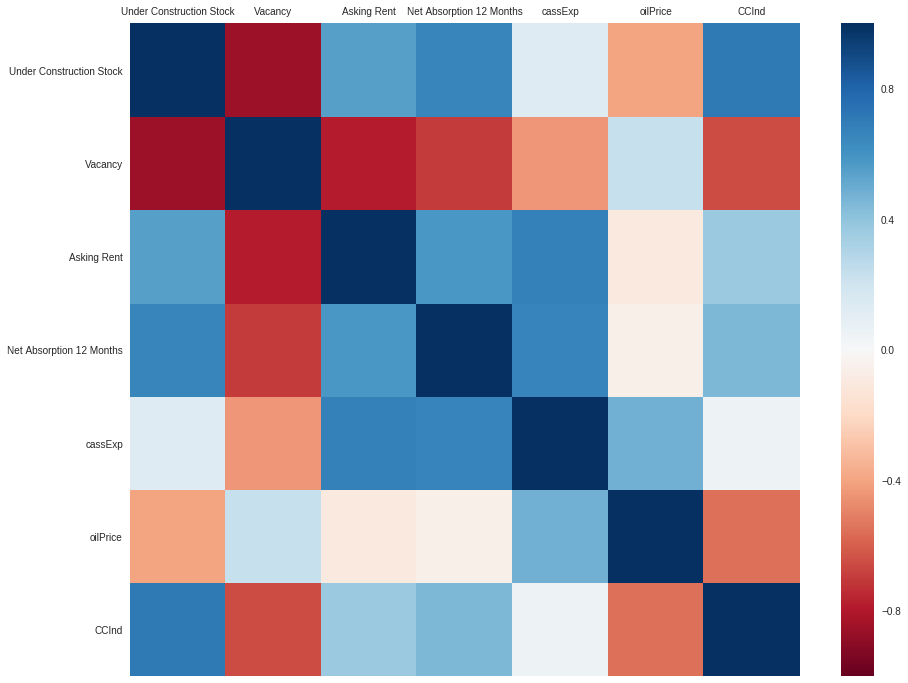

In [50]:
corr = comp.corr()
plt.figure(figsize = (15,12))
ax = sns.heatmap(corr, cmap="RdBu")
ax.xaxis.tick_top()
plt.show()

In [0]:
#testTS = indTS.reindex(prrTS.index, method='nearest', tolerance='10Days').dropna()

In [0]:
#test = testTS.assign(Expenditures = comp['cassExp'])
#test = test.assign(PRRatio = comp['Value'])
#test = test.assign(OilPrice = comp['oilPrice'])
#test.tail()

In [17]:
exp = expTS.reindex(indTS.index, method='nearest', tolerance='5Days').dropna()
test = indTS.assign(Expenditures = exp)
crudeOil = crude_oilTS.reindex(indTS.index, method='nearest', tolerance='5Days').dropna()
test = test.assign(OilPrice = crudeOil).dropna()
test.head()

,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months,Expenditures,OilPrice
Dates,,,,,,
2002-12-31,131176952.0,0.087,5.79,26566660,1.200,30.05
2003-03-31,105012888.0,0.088,5.78,39397728,1.285,27.22
2003-06-30,130056880.0,0.089,5.78,57215952,1.306,27.11
2003-09-30,151599184.0,0.089,5.78,64857872,1.425,26.82
2003-12-31,154962960.0,0.090,5.79,73606000,1.376,29.87


In [18]:
test_nor = (test - test.min()) / (test.max() - test.min())
len(test_nor)

64

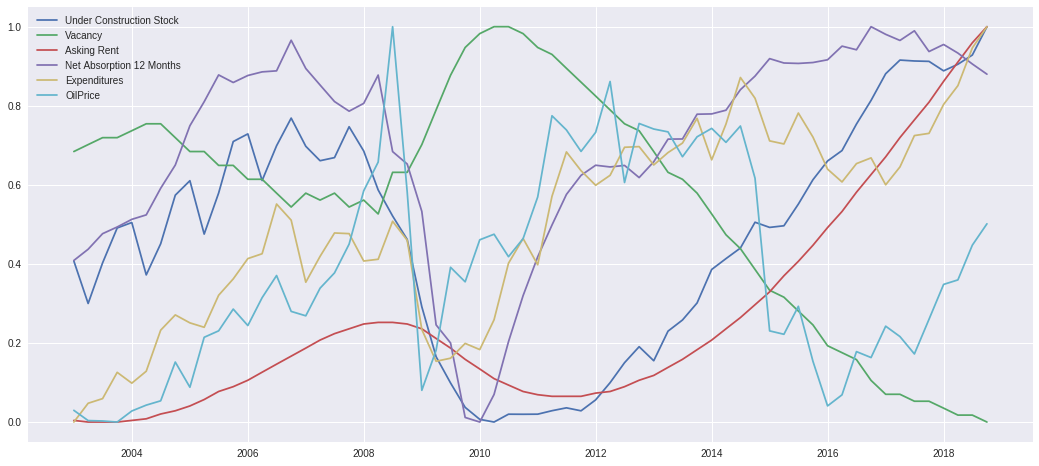

In [49]:
plt.figure(figsize = (18,8))
plt.plot(test_nor)
plt.legend(labels=test_nor.columns)
plt.show()

In [20]:
test_nor.corr()

,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months,Expenditures,OilPrice
Under Construction Stock,1.000000,-0.849074,0.690186,0.795665,0.310991,-0.400773
Vacancy,-0.849074,1.000000,-0.897135,-0.797162,-0.628050,0.231611
Asking Rent,0.690186,-0.897135,1.000000,0.546480,0.646654,-0.094810
Net Absorption 12 Months,0.795665,-0.797162,0.546480,1.000000,0.617827,-0.059524
Expenditures,0.310991,-0.628050,0.646654,0.617827,1.000000,0.482031
OilPrice,-0.400773,0.231611,-0.094810,-0.059524,0.482031,1.000000


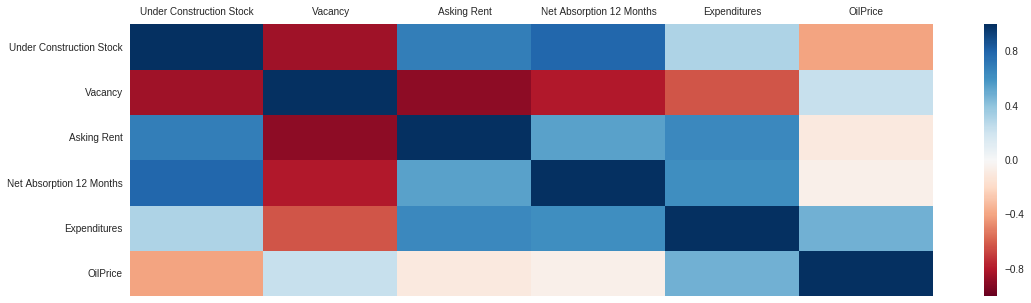

In [21]:
corr = test_nor.corr()
plt.figure(figsize = (18,5))
ax = sns.heatmap(corr, cmap="RdBu")
ax.xaxis.tick_top()
plt.show()

In [22]:
test_nor['Expenditures'].corr(test_nor['Under Construction Stock'].shift(-2)),test_nor['Expenditures'].corr(test_nor['Under Construction Stock'].shift(-1)),test_nor['Expenditures'].corr(test_nor['Under Construction Stock'].shift(0)),test_nor['Expenditures'].corr(test_nor['Under Construction Stock'].shift(1)),test_nor['Expenditures'].corr(test_nor['Under Construction Stock'].shift(2))

(0.29137302254871655,
 0.31837247586683565,
 0.31099080918851774,
 0.24239757752893862,
 0.182589954899682)

In [0]:
seq_len = 150
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.2
decay = 0.5
epochs = 10